# Branching & Row Operations

This notebook covers three related pipeline features:

1. **`branch`** — Create a secondary pipeline from the main dataframe or from storage
2. **`apply_to_rows`** — Filter rows by condition, transform them, merge back
3. **Skip options** — Conditionally disable transformers, branches, or entire pipelines

All three enable **conditional execution** and **forking logic** in your pipelines.

In [1]:
import polars as pl

from nebula import TransformerPipeline
from nebula.storage import nebula_storage as ns
from nebula.transformers import (
    AddLiterals,
    AssertNotEmpty,
    DropColumns,
    Filter,
    RenameColumns,
    SelectColumns,
    When,
)

## Sample Data

In [2]:
# Main orders dataframe
orders_df = pl.DataFrame({
    "order_id": [1, 2, 3, 4, 5, 6],
    "customer": ["Alice", "Bob", "Charlie", "Diana", "Eve", "Frank"],
    "amount": [150.0, 80.0, 320.0, 45.0, 200.0, 95.0],
    "status": ["completed", "pending", "completed", "pending", "completed", "cancelled"],
})

# Customer metadata (for joins)
customers_df = pl.DataFrame({
    "customer": ["Alice", "Bob", "Charlie", "Diana"],
    "tier": ["gold", "silver", "gold", "bronze"],
    "region": ["US", "EU", "US", "APAC"],
})

print("Orders:")
print(orders_df)
print("\nCustomers:")
print(customers_df)

Orders:
shape: (6, 4)
┌──────────┬──────────┬────────┬───────────┐
│ order_id ┆ customer ┆ amount ┆ status    │
│ ---      ┆ ---      ┆ ---    ┆ ---       │
│ i64      ┆ str      ┆ f64    ┆ str       │
╞══════════╪══════════╪════════╪═══════════╡
│ 1        ┆ Alice    ┆ 150.0  ┆ completed │
│ 2        ┆ Bob      ┆ 80.0   ┆ pending   │
│ 3        ┆ Charlie  ┆ 320.0  ┆ completed │
│ 4        ┆ Diana    ┆ 45.0   ┆ pending   │
│ 5        ┆ Eve      ┆ 200.0  ┆ completed │
│ 6        ┆ Frank    ┆ 95.0   ┆ cancelled │
└──────────┴──────────┴────────┴───────────┘

Customers:
shape: (4, 3)
┌──────────┬────────┬────────┐
│ customer ┆ tier   ┆ region │
│ ---      ┆ ---    ┆ ---    │
│ str      ┆ str    ┆ str    │
╞══════════╪════════╪════════╡
│ Alice    ┆ gold   ┆ US     │
│ Bob      ┆ silver ┆ EU     │
│ Charlie  ┆ gold   ┆ US     │
│ Diana    ┆ bronze ┆ APAC   │
└──────────┴────────┴────────┘


---
# Part 1: Branch Pipelines

Branch pipelines are **secondary pipelines** that:
- Originate from the **primary dataframe** or from **Nebula Storage**
- Can be merged back via **join**, **append**, or not at all (**dead-end**)
- Leave the **main flow unchanged** until the merge point

## Branch Input: Where does the data come from?

![Branch Input Options](images/branch_df_input.jpg)

- **With `"storage": key`** — Branch reads from a previously stored dataframe
- **Without `storage`** — Branch gets a copy of the current dataframe

## Branch Output: How is it merged back?

![Branch Output Options](images/branch_df_output.jpg)

| `end` value | Description |
|-------------|-------------|
| `"dead-end"` | Branch result is discarded (useful for side-effects like logging/storing) |
| `"join"` | Branch result is joined to main dataframe (requires `on`, `how`) |
| `"append"` | Branch result is vertically concatenated to main dataframe |

### 1.1 Branch from Storage → Join Back

Process a stored dataframe and join the result to the main flow.

In [3]:
# Store customer metadata for later use
ns.set("customer_metadata", customers_df)

# Pipeline: enrich orders with customer tier
pipe_branch_storage_join = TransformerPipeline(
    [
        # Branch transforms the stored customer data
        SelectColumns(columns=["customer", "tier"]),
        RenameColumns(mapping={"tier": "customer_tier"}),
    ],
    branch={
        "storage": "customer_metadata",  # Input from storage
        "end": "join",                   # Merge via join
        "on": "customer",                # Join key
        "how": "left",                   # Keep all orders
        "skip": False,
    },
    name="Enrich with Customer Tier",
)

pipe_branch_storage_join.show(add_params=True)

2025-12-26 00:51:09,911 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "customer_metadata". 


*** Enrich with Customer Tier *** (2 transformations)
------ BRANCH (from storage: customer_metadata) ------
>> Branch (2 transformations):
     - SelectColumns -> PARAMS: columns=['customer', 'tier']
     - RenameColumns -> PARAMS: mapping={'tier': 'customer_tier'}
<<< Join DFs >>>
  - how: left
  - on: customer


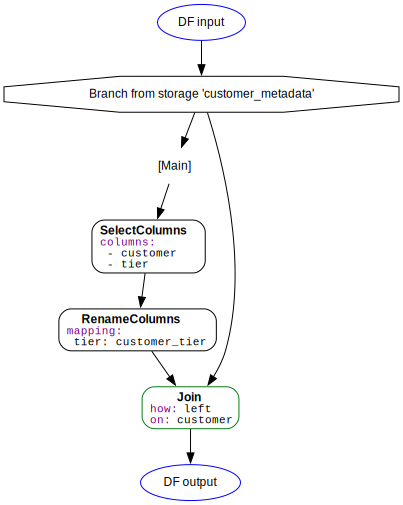

In [4]:
pipe_branch_storage_join.plot(add_params=True)

In [5]:
result = pipe_branch_storage_join.run(orders_df)
result

2025-12-26 00:51:11,336 | [INFO]: Starting pipeline 'Enrich with Customer Tier' 
2025-12-26 00:51:11,339 | [INFO]: Entering branch 
2025-12-26 00:51:11,339 | [INFO]: Running 'SelectColumns' ... 
2025-12-26 00:51:11,346 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-26 00:51:11,346 | [INFO]: Running 'RenameColumns' ... 
2025-12-26 00:51:11,346 | [INFO]: Completed 'RenameColumns' in 0.0s 
2025-12-26 00:51:11,346 | [INFO]: Pipeline 'Enrich with Customer Tier' completed in 0.0s 


order_id,customer,amount,status,customer_tier
i64,str,f64,str,str
1,"""Alice""",150.0,"""completed""","""gold"""
2,"""Bob""",80.0,"""pending""","""silver"""
3,"""Charlie""",320.0,"""completed""","""gold"""
4,"""Diana""",45.0,"""pending""","""bronze"""
5,"""Eve""",200.0,"""completed""",null
6,"""Frank""",95.0,"""cancelled""",null


### 1.2 Branch from Primary DF → Join Back

Fork from the current dataframe, transform it, and join back. Useful for creating derived columns from aggregations.

In [6]:
def calculate_customer_totals(df):
    """Aggregate total spend per customer."""
    return df.group_by("customer").agg(
        pl.col("amount").sum().alias("total_spend")
    )


pipe_branch_primary_join = TransformerPipeline(
    [
        calculate_customer_totals,
    ],
    branch={
        # No "storage" key = branch from current dataframe
        "end": "join",
        "on": "customer",
        "how": "left",
    },
    name="Add Customer Totals",
)

result = pipe_branch_primary_join.run(orders_df)
result

2025-12-26 00:51:11,887 | [INFO]: Starting pipeline 'Add Customer Totals' 
2025-12-26 00:51:11,890 | [INFO]: Entering branch 
2025-12-26 00:51:11,893 | [INFO]: Running 'calculate_customer_totals' ... 
2025-12-26 00:51:11,893 | [INFO]: Completed 'calculate_customer_totals' in 0.0s 
2025-12-26 00:51:11,893 | [INFO]: Pipeline 'Add Customer Totals' completed in 0.0s 


order_id,customer,amount,status,total_spend
i64,str,f64,str,f64
1,"""Alice""",150.0,"""completed""",150.0
2,"""Bob""",80.0,"""pending""",80.0
3,"""Charlie""",320.0,"""completed""",320.0
4,"""Diana""",45.0,"""pending""",45.0
5,"""Eve""",200.0,"""completed""",200.0
6,"""Frank""",95.0,"""cancelled""",95.0


### 1.3 Branch → Append

Process a subset and append it back (vertical concatenation).

In [7]:
pipe_branch_append = TransformerPipeline(
    [
        # Branch: duplicate high-value orders with a flag
        Filter(input_col="amount", perform="keep", operator="ge", value=200),
        AddLiterals(data=[{"alias": "is_duplicate", "value": True}]),
    ],
    branch={
        "end": "append",  # Vertical concatenation
    },
    # Main flow also needs the column for schema compatibility
    otherwise=[
        AddLiterals(data=[{"alias": "is_duplicate", "value": False}]),
    ],
    name="Duplicate High-Value Orders",
)

result = pipe_branch_append.run(orders_df)
print(f"Original: {len(orders_df)} rows, After append: {len(result)} rows")
result.sort("order_id")

2025-12-26 00:51:15,988 | [INFO]: Starting pipeline 'Duplicate High-Value Orders' 
2025-12-26 00:51:15,991 | [INFO]: Entering branch 
2025-12-26 00:51:15,994 | [INFO]: Running 'Filter' ... 
2025-12-26 00:51:15,995 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 00:51:15,997 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:15,999 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:16,001 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:16,002 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:16,008 | [INFO]: Pipeline 'Duplicate High-Value Orders' completed in 0.0s 


Original: 6 rows, After append: 8 rows


order_id,customer,amount,status,is_duplicate
i64,str,f64,str,bool
1,"""Alice""",150.0,"""completed""",false
2,"""Bob""",80.0,"""pending""",false
3,"""Charlie""",320.0,"""completed""",true
3,"""Charlie""",320.0,"""completed""",false
4,"""Diana""",45.0,"""pending""",false
5,"""Eve""",200.0,"""completed""",true
5,"""Eve""",200.0,"""completed""",false
6,"""Frank""",95.0,"""cancelled""",false


### 1.4 Branch → Dead-End

Process data without merging back. Useful for:
- Storing intermediate results
- Logging/auditing
- Side-effect operations

In [8]:
def store_high_value_for_review(df):
    """Store high-value orders for manual review."""
    ns.set("high_value_review", df)
    print(f"📋 Stored {len(df)} high-value orders for review")
    return df


pipe_branch_deadend = TransformerPipeline(
    [
        Filter(input_col="amount", perform="keep", operator="ge", value=200),
        store_high_value_for_review,
    ],
    branch={
        "end": "dead-end",  # Don't merge back
    },
    name="Archive High-Value Orders",
)

result = pipe_branch_deadend.run(orders_df)
print(f"\nOutput is unchanged ({len(result)} rows):")
result

2025-12-26 00:51:16,561 | [INFO]: Starting pipeline 'Archive High-Value Orders' 
2025-12-26 00:51:16,576 | [INFO]: Entering branch 
2025-12-26 00:51:16,579 | [INFO]: Running 'Filter' ... 
2025-12-26 00:51:16,582 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 00:51:16,583 | [INFO]: Running 'store_high_value_for_review' ... 
2025-12-26 00:51:16,583 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "high_value_review". 
2025-12-26 00:51:16,585 | [INFO]: Completed 'store_high_value_for_review' in 0.0s 
2025-12-26 00:51:16,586 | [INFO]: Pipeline 'Archive High-Value Orders' completed in 0.0s 


📋 Stored 2 high-value orders for review

Output is unchanged (6 rows):


order_id,customer,amount,status
i64,str,f64,str
1,"""Alice""",150.0,"""completed"""
2,"""Bob""",80.0,"""pending"""
3,"""Charlie""",320.0,"""completed"""
4,"""Diana""",45.0,"""pending"""
5,"""Eve""",200.0,"""completed"""
6,"""Frank""",95.0,"""cancelled"""


In [9]:
# But the high-value orders were stored separately
print("Stored for review:")
ns.get("high_value_review")

Stored for review:


order_id,customer,amount,status
i64,str,f64,str
3,"""Charlie""",320.0,"""completed"""
5,"""Eve""",200.0,"""completed"""


### 1.5 The `otherwise` Parameter

When using `branch` (without storage) or `apply_to_rows`, you can specify an `otherwise` pipeline that processes the **main dataframe** while the branch processes its fork.

This is useful when both paths need compatible schemas for merging.

In [10]:
pipe_with_otherwise = TransformerPipeline(
    [
        # Branch: mark completed orders
        Filter(input_col="status", perform="keep", operator="eq", value="completed"),
        AddLiterals(data=[{"alias": "processed", "value": "completed_flow"}]),
    ],
    branch={
        "end": "append",
    },
    otherwise=[
        # Main flow: mark non-completed orders
        Filter(input_col="status", perform="remove", operator="eq", value="completed"),
        AddLiterals(data=[{"alias": "processed", "value": "other_flow"}]),
    ],
    name="Parallel Processing Paths",
)

result = pipe_with_otherwise.run(orders_df)
result.sort("order_id")

2025-12-26 00:51:17,495 | [INFO]: Starting pipeline 'Parallel Processing Paths' 
2025-12-26 00:51:17,495 | [INFO]: Entering branch 
2025-12-26 00:51:17,495 | [INFO]: Running 'Filter' ... 
2025-12-26 00:51:17,500 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 00:51:17,502 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:17,504 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:17,505 | [INFO]: Running 'Filter' ... 
2025-12-26 00:51:17,507 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 00:51:17,508 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:17,508 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:17,511 | [INFO]: Pipeline 'Parallel Processing Paths' completed in 0.0s 


order_id,customer,amount,status,processed
i64,str,f64,str,str
1,"""Alice""",150.0,"""completed""","""completed_flow"""
2,"""Bob""",80.0,"""pending""","""other_flow"""
3,"""Charlie""",320.0,"""completed""","""completed_flow"""
4,"""Diana""",45.0,"""pending""","""other_flow"""
5,"""Eve""",200.0,"""completed""","""completed_flow"""
6,"""Frank""",95.0,"""cancelled""","""other_flow"""


---
# Part 2: Apply to Rows

`apply_to_rows` lets you:
1. **Filter** rows matching a condition
2. **Transform** only those rows
3. **Merge** them back with the rest

This is simpler than `branch` when you just need to transform a subset of rows.

### 2.1 Basic Apply to Rows

Apply a discount only to high-value orders.

In [11]:
pipe_apply_basic = TransformerPipeline(
    [
        # These transformers apply ONLY to rows where amount >= 200
        AddLiterals(data=[{"alias": "discount", "value": 0.1}]),
    ],
    apply_to_rows={
        "input_col": "amount",
        "operator": "ge",
        "value": 200,
    },
    otherwise=[
        # Rows where amount < 200 get no discount
        AddLiterals(data=[{"alias": "discount", "value": 0.0}]),
    ],
    name="Apply Discount to High-Value",
    allow_missing_columns=True,
)

result = pipe_apply_basic.run(orders_df)
result.sort("order_id")

2025-12-26 00:51:18,646 | [INFO]: Starting pipeline 'Apply Discount to High-Value' 
2025-12-26 00:51:18,647 | [INFO]: Entering apply_to_rows 
2025-12-26 00:51:18,653 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:18,655 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:18,655 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:18,656 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:18,656 | [INFO]: Pipeline 'Apply Discount to High-Value' completed in 0.0s 


order_id,customer,amount,status,discount
i64,str,f64,str,f64
1,"""Alice""",150.0,"""completed""",0.0
2,"""Bob""",80.0,"""pending""",0.0
3,"""Charlie""",320.0,"""completed""",0.1
4,"""Diana""",45.0,"""pending""",0.0
5,"""Eve""",200.0,"""completed""",0.1
6,"""Frank""",95.0,"""cancelled""",0.0


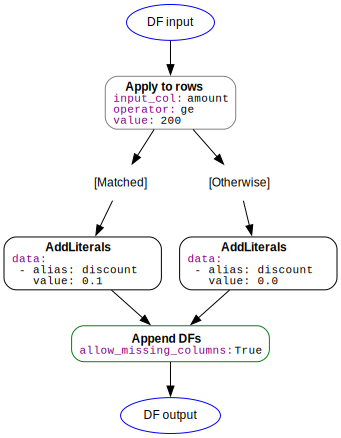

In [12]:
pipe_apply_basic.plot(add_params=True)

### 2.2 Apply to Rows with Column Comparison

You can compare columns to each other using `comparison_column` instead of `value`.

In [13]:
# Add a threshold column
orders_with_threshold = orders_df.with_columns(
    pl.lit(100.0).alias("threshold")
)

pipe_apply_col_compare = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "above_threshold", "value": True}]),
    ],
    apply_to_rows={
        "input_col": "amount",
        "operator": "gt",
        "comparison_column": "threshold",  # Compare amount > threshold
    },
    otherwise=[
        AddLiterals(data=[{"alias": "above_threshold", "value": False}]),
    ],
    name="Compare to Threshold",
)

result = pipe_apply_col_compare.run(orders_with_threshold)
result.sort("order_id")

2025-12-26 00:51:20,514 | [INFO]: Starting pipeline 'Compare to Threshold' 
2025-12-26 00:51:20,516 | [INFO]: Entering apply_to_rows 
2025-12-26 00:51:20,522 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:20,522 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:20,522 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:20,522 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:20,522 | [INFO]: Pipeline 'Compare to Threshold' completed in 0.0s 


order_id,customer,amount,status,threshold,above_threshold
i64,str,f64,str,f64,bool
1,"""Alice""",150.0,"""completed""",100.0,true
2,"""Bob""",80.0,"""pending""",100.0,false
3,"""Charlie""",320.0,"""completed""",100.0,true
4,"""Diana""",45.0,"""pending""",100.0,false
5,"""Eve""",200.0,"""completed""",100.0,true
6,"""Frank""",95.0,"""cancelled""",100.0,false


### 2.3 Apply to Rows → Dead-End

Process matching rows but don't merge them back (remove them from output).

In [14]:
def log_cancelled(df):
    """Log cancelled orders (side effect)."""
    print(f"⚠️ Found {len(df)} cancelled orders")
    return df


pipe_apply_deadend = TransformerPipeline(
    [
        log_cancelled,
    ],
    apply_to_rows={
        "input_col": "status",
        "operator": "eq",
        "value": "cancelled",
        "dead-end": True,  # Don't merge back (removes cancelled)
    },
    name="Remove Cancelled Orders",
)

result = pipe_apply_deadend.run(orders_df)
print(f"\nOutput excludes cancelled ({len(result)} rows):")
result

2025-12-26 00:51:21,114 | [INFO]: Starting pipeline 'Remove Cancelled Orders' 
2025-12-26 00:51:21,117 | [INFO]: Entering apply_to_rows 
2025-12-26 00:51:21,123 | [INFO]: Running 'log_cancelled' ... 
2025-12-26 00:51:21,125 | [INFO]: Completed 'log_cancelled' in 0.0s 
2025-12-26 00:51:21,127 | [INFO]: Pipeline 'Remove Cancelled Orders' completed in 0.0s 


⚠️ Found 1 cancelled orders

Output excludes cancelled (5 rows):


order_id,customer,amount,status
i64,str,f64,str
1,"""Alice""",150.0,"""completed"""
2,"""Bob""",80.0,"""pending"""
3,"""Charlie""",320.0,"""completed"""
4,"""Diana""",45.0,"""pending"""
5,"""Eve""",200.0,"""completed"""


### 2.4 Apply to Rows — Available Operators

| Operator | Description | Value Type |
|----------|-------------|------------|
| `eq`, `ne` | Equal / Not equal | Any |
| `lt`, `le`, `gt`, `ge` | Comparisons | Comparable |
| `is_null`, `is_not_null` | Null checks | (no value) |
| `is_nan`, `is_not_nan` | NaN checks | (no value) |
| `is_in`, `is_not_in` | Set membership | List/Set |
| `is_between` | Range (inclusive) | [lower, upper] |
| `contains`, `starts_with`, `ends_with` | String matching | String |

In [15]:
# Example: is_in operator
pipe_apply_isin = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "needs_action", "value": True}]),
    ],
    apply_to_rows={
        "input_col": "status",
        "operator": "is_in",
        "value": ["pending", "cancelled"],  # List of values
    },
    otherwise=[
        AddLiterals(data=[{"alias": "needs_action", "value": False}]),
    ],
    name="Flag Actionable Orders",
)

pipe_apply_isin.run(orders_df).sort("order_id")

2025-12-26 00:51:21,927 | [INFO]: Starting pipeline 'Flag Actionable Orders' 
2025-12-26 00:51:21,928 | [INFO]: Entering apply_to_rows 
2025-12-26 00:51:21,956 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:21,957 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:21,958 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:21,959 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:21,961 | [INFO]: Pipeline 'Flag Actionable Orders' completed in 0.0s 


order_id,customer,amount,status,needs_action
i64,str,f64,str,bool
1,"""Alice""",150.0,"""completed""",false
2,"""Bob""",80.0,"""pending""",true
3,"""Charlie""",320.0,"""completed""",false
4,"""Diana""",45.0,"""pending""",true
5,"""Eve""",200.0,"""completed""",false
6,"""Frank""",95.0,"""cancelled""",true


---
# Part 3: Skip Options

Skip options let you **conditionally disable** parts of your pipeline based on runtime flags.

This is useful for:
- Feature flags (enable/disable processing paths)
- Environment-specific behavior (dev vs prod)
- Debugging (skip expensive operations)

### 3.1 Skip/Perform at Pipeline Level

Use `skip=True` or `perform=False` to disable an entire pipeline.

In [16]:
# Feature flag example
ENABLE_EXPENSIVE_ENRICHMENT = False

pipe_skippable = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "enriched", "value": True}]),
        # ... expensive transformations ...
    ],
    skip=not ENABLE_EXPENSIVE_ENRICHMENT,  # Skip if feature disabled
    name="Expensive Enrichment",
)

# Alternatively use `perform`:
pipe_skippable_alt = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "enriched", "value": True}]),
    ],
    perform=ENABLE_EXPENSIVE_ENRICHMENT,  # Only run if True
    name="Expensive Enrichment",
)

print("Pipeline with skip=True returns empty:")
pipe_skippable.show()

Pipeline with skip=True returns empty:
*** Expensive Enrichment ***


In [17]:
# When skipped, pipeline acts as pass-through
result = pipe_skippable.run(orders_df)
print(f"Output unchanged when skipped: {len(result)} rows, columns: {result.columns}")

2025-12-26 00:51:23,092 | [INFO]: Starting pipeline 'Expensive Enrichment' 
2025-12-26 00:51:23,095 | [INFO]: Pipeline 'Expensive Enrichment' completed in 0.0s 


Output unchanged when skipped: 6 rows, columns: ['order_id', 'customer', 'amount', 'status']


### 3.2 Skip/Perform in Branch and Apply-to-Rows

The `branch` and `apply_to_rows` dictionaries also accept `skip` and `perform` keys.

In [18]:
ENABLE_AUDIT = False

pipe_conditional_branch = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "audit_flag", "value": "audited"}]),
    ],
    branch={
        "end": "dead-end",
        "skip": not ENABLE_AUDIT,  # Skip branch if audit disabled
    },
    name="Conditional Audit Branch",
)

# Branch is skipped, only `otherwise` runs (if provided)
result = pipe_conditional_branch.run(orders_df)
print(f"Branch skipped - output unchanged: {result.columns}")

2025-12-26 00:51:23,682 | [INFO]: Starting pipeline 'Conditional Audit Branch' 
2025-12-26 00:51:23,686 | [INFO]: Pipeline 'Conditional Audit Branch' completed in 0.0s 


Branch skipped - output unchanged: ['order_id', 'customer', 'amount', 'status']


In [19]:
# Same for apply_to_rows
APPLY_DISCOUNT = True

pipe_conditional_apply = TransformerPipeline(
    [
        AddLiterals(data=[{"alias": "has_discount", "value": True}]),
    ],
    apply_to_rows={
        "input_col": "amount",
        "operator": "ge",
        "value": 200,
        "perform": APPLY_DISCOUNT,  # Only apply if True
    },
    otherwise=[
        AddLiterals(data=[{"alias": "has_discount", "value": False}]),
    ],
    name="Conditional Discount",
)

pipe_conditional_apply.run(orders_df).sort("order_id")

2025-12-26 00:51:24,148 | [INFO]: Starting pipeline 'Conditional Discount' 
2025-12-26 00:51:24,158 | [INFO]: Entering apply_to_rows 
2025-12-26 00:51:24,163 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:24,166 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:24,166 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:24,168 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:24,170 | [INFO]: Pipeline 'Conditional Discount' completed in 0.0s 


order_id,customer,amount,status,has_discount
i64,str,f64,str,bool
1,"""Alice""",150.0,"""completed""",false
2,"""Bob""",80.0,"""pending""",false
3,"""Charlie""",320.0,"""completed""",true
4,"""Diana""",45.0,"""pending""",false
5,"""Eve""",200.0,"""completed""",true
6,"""Frank""",95.0,"""cancelled""",false


### 3.3 Combining Skip with Otherwise

When a branch/apply_to_rows is skipped, the `otherwise` pipeline still runs on the full dataframe.

In [20]:
pipe_skip_with_otherwise = TransformerPipeline(
    [
        # This branch is skipped
        AddLiterals(data=[{"alias": "from_branch", "value": True}]),
    ],
    branch={
        "end": "append",
        "skip": True,
    },
    otherwise=[
        # This runs on the full dataframe when branch is skipped
        AddLiterals(data=[{"alias": "from_otherwise", "value": True}]),
    ],
    name="Skip Branch, Run Otherwise",
)

result = pipe_skip_with_otherwise.run(orders_df)
print(f"Only otherwise columns: {result.columns}")
result

2025-12-26 00:51:24,919 | [INFO]: Starting pipeline 'Skip Branch, Run Otherwise' 
2025-12-26 00:51:24,922 | [INFO]: Running 'AddLiterals' ... 
2025-12-26 00:51:24,925 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-26 00:51:24,926 | [INFO]: Pipeline 'Skip Branch, Run Otherwise' completed in 0.0s 


Only otherwise columns: ['order_id', 'customer', 'amount', 'status', 'from_otherwise']


order_id,customer,amount,status,from_otherwise
i64,str,f64,str,bool
1,"""Alice""",150.0,"""completed""",true
2,"""Bob""",80.0,"""pending""",true
3,"""Charlie""",320.0,"""completed""",true
4,"""Diana""",45.0,"""pending""",true
5,"""Eve""",200.0,"""completed""",true
6,"""Frank""",95.0,"""cancelled""",true


---
## Summary

### Branch
| Config Key | Description |
|------------|-------------|
| `storage` | Key to read input from (omit to use current df) |
| `end` | `"dead-end"`, `"join"`, or `"append"` |
| `on` | Join key(s) (for `end="join"`) |
| `how` | Join type: `"inner"`, `"left"`, `"right"`, `"full"` |
| `left_on` / `right_on` | Different key names for join |
| `suffix` | Suffix for duplicate column names |
| `broadcast` | Spark: broadcast right df (for small tables) |
| `skip` / `perform` | Conditionally disable the branch |

### Apply to Rows
| Config Key | Description |
|------------|-------------|
| `input_col` | Column to filter on |
| `operator` | Comparison operator (see table above) |
| `value` | Value to compare against |
| `comparison_column` | Compare to another column (instead of value) |
| `dead-end` | If True, matching rows are removed |
| `skip_if_empty` | Skip if no rows match |
| `skip` / `perform` | Conditionally disable |

### Skip Options
- `skip=True` or `perform=False` → Pipeline/branch/apply is disabled
- When skipped, `otherwise` still runs (if provided)

**Next notebooks:**
- **Storage & Runtime Dynamics** — caching, LazyTransformer, debugging
- **YAML Configuration** — declarative pipeline definitions